In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import glob
from PIL import Image
from collections import defaultdict
import math
from copy import deepcopy
import pandas as pd
import struct, os
import re, numpy as np
# from skimage import transform
import itertools, operator
import pickle
from torch.optim.lr_scheduler import _LRScheduler
from nltk.corpus import wordnet as wn

import sys
import xml.etree.ElementTree as ET

import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as td 
import torchvision as tv
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import Data
import build
from build import Yolov2
import bbox

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'
batch_size = 32
meta = defaultdict()
meta['anchors'] = 5
meta['classes'] = 20
meta['batch_size'] = batch_size
meta['threshold'] = 0.6
meta['anchor_bias'] = np.array([1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52])
meta['scale_no_obj'] = 1
meta['scale_coords'] = 1
meta['scale_class'] = 1
meta['scale_obj']  = 5
meta['iteration'] = 0 

In [4]:
train_set, test_set = Data.getdata(dataset_root_dir)
meta['train_samples'] = len(train_set)
meta['iterations_per_epoch'] = meta['train_samples']/batch_size

In [5]:
# print(len(train_set))
# for i in range(len(test_set)):
#     print(i, len(test_set[i]['bboxes']))
# k = test_set[3622]

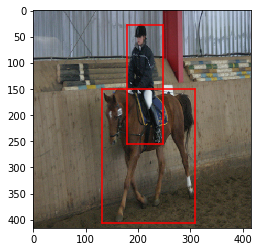

In [6]:
def draw_boundary_box_fraction(image_dict):
    """Show image with landmarks"""
    image = image_dict['image']
    height, width, channels = image.shape
    bboxes = image_dict['bboxes']
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    plt.imshow(image)
    for bbox in bboxes:
        x = bbox[1] * width
        y = bbox[2] * height
        w = bbox[3] * width
        h = bbox[4] * height
        xmin = max(0, int(x - w*0.5))
        ymin = max(0, int(y - h*0.5))
        xmax = min(int(x + w*0.5), width)
        ymax = min(int(y + h*0.5), height)
        plt.plot((xmin, xmin), (ymin, ymax), 'r')
        plt.plot((xmin, xmax), (ymin, ymin), 'r')
        plt.plot((xmax, xmax), (ymin, ymax), 'r')
        plt.plot((xmin, xmax), (ymax, ymax), 'r')
        
def draw_bbox_torch(img_dict):
    image = np.transpose(np.array(img_dict['image'].numpy()), (1, 2, 0))
    bboxes = img_dict['bboxes'].numpy()
    n_true = np.sum(bboxes[:, 0]!=-1)
    bboxes = bboxes[:n_true]
    draw_boundary_box_fraction({"image": image, 'bboxes': bboxes})

def draw_bbox_nms(torch_img, nms_output):
    image = np.transpose(np.array(torch_img.data.numpy()), (1, 2, 0))
    bboxes = nms_output[:, :4].data.numpy()
    bboxes = np.concatenate([np.zeros(len(bboxes)).reshape(len(bboxes), 1), bboxes], 1)
    print (bboxes)
    draw_boundary_box_fraction({"image": image, 'bboxes': bboxes})

draw_bbox_torch(train_set[0])

In [7]:
net = Yolov2()
net = build.load_pretrained_weights(net)
build.model_freeze_upto(net, 36)
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)
net = net.to(device)

<generator object Module.children at 0x7fa9e1c41518>
conv19.weight torch.Size([1024, 1024, 3, 3]) True
batchnorm19.weight torch.Size([1024]) True
batchnorm19.bias torch.Size([1024]) True
conv20.weight torch.Size([1024, 1024, 3, 3]) True
batchnorm20.weight torch.Size([1024]) True
batchnorm20.bias torch.Size([1024]) True
conv21.weight torch.Size([1024, 3072, 3, 3]) True
batchnorm21.weight torch.Size([1024]) True
batchnorm21.bias torch.Size([1024]) True
conv22.weight torch.Size([125, 1024, 1, 1]) True
conv22.bias torch.Size([125]) True


In [8]:
x = train_set[0]['image'].view(1,3,416,416).float()
y = net(x.to(device))
nms = bbox.get_nms_boxes(y, 0, 0)
print(nms)
# draw_bbox_nms(x[0,:,:,:].cpu(), nms[0].cpu())

tensor([[0.0267, 0.0324, 0.0803, 0.2869],
        [0.0534, 0.0280, 0.5397, 0.4683],
        [0.0270, 0.0439, 0.5797, 0.4409],
        ...,
        [0.9809, 0.9525, 0.7241, 0.1862],
        [0.9676, 0.9900, 0.3477, 0.2073],
        [0.9851, 0.9463, 1.4680, 1.0658]], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor(1, device='cuda:0', dtype=torch.uint8)


IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

In [ ]:
import nntools as nt 
import yolo2loss as loss 
class YOLOStatsManager(nt.StatsManager):
    def __init__(self):
        super(YOLOStatsManager, self).__init__()

    def init(self):
        super(YOLOStatsManager, self).init()
        #self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d): 
        super(YOLOStatsManager, self).accumulate(loss)
#         _, l = torch.max(y, 1)
#         self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(YOLOStatsManager, self).summarize() 
#         accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss}

In [ ]:
# !rm -r yolo_voc1

lr = 0.00025
# net = Yolo_detector()
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = YOLOStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, meta, output_dir="yolo_voc1", 
                     batch_size = batch_size, perform_validation_during_training=True)

In [ ]:
def plot(exp, fig, axes):
    axes.clear()
    axes.plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="training loss")
    axes.plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="evaluation loss")
    plt.tight_layout()
    fig.canvas.draw()
    axes.legend()

fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))